In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from pyproj import Proj, transform
import contextily as ctx
from shapely.geometry import box
import fiona

# Documentation for how to use data here: https://www.pge.com/b2b/distribution-resource-planning/downloads/integration-capacity/PGE_ICA_Map_User_Guide.pdf
gdb_path = "../data/raw/ICADisplay.gdb"

# List all layers
layers = fiona.listlayers(gdb_path)
# [
# 'LineDetail',
# 'ICANotAvailable', 
# 'FeederDetail', 
# 'Substations', 
# 'FeederLoadProfile', 
# 'SubstationLoadProfile', 
# 'TransmissionLines', 
# 'networkedSecondaryBuffer', 
# 'FeederSubstationSummary', 
# 'ICAEstimatedCapacitySummary'
# ]

/var/folders/gr/g6k4s8t13n98c8bw4ywdpxrr0000gn/T/ipykernel_39364/3430634474.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
feeder = gpd.read_file("../data/raw/ICADisplay.gdb", driver='fileGDB', layer="FeederDetail")
feeder_load = gpd.read_file("../data/raw/ICADisplay.gdb", driver='fileGDB', layer="FeederLoadProfile")

line = gpd.read_file("../data/raw/ICADisplay.gdb", driver='fileGDB', layer="LineDetail")

substations = gpd.read_file("../data/raw/ICADisplay.gdb", driver='fileGDB', layer="Substations")
substation_load = gpd.read_file("../data/raw/ICADisplay.gdb", driver='fileGDB', layer="SubstationLoadProfile")

In [6]:
# Print names of columns
dataframes = {
    'feeder': feeder,
    'feeder_load': feeder_load,
    'line': line,
    'substations': substations,
    'substation_load': substation_load
}

# Printing column keys in a table format
for name, df in dataframes.items():
    print(f"DataFrame: {name}")
    print(df.columns.tolist())
    print()

DataFrame: feeder
['Substation', 'FeederID', 'Feeder_Name', 'Nominal_Voltage', 'Load_Profile_Redaction', 'ResCust', 'ComCust', 'IndCust', 'AgrCust', 'OthCust', 'Existing_DG', 'Queued_DG', 'Total_DG', 'Show', 'VOLTNUM', 'Shape_Length', 'geometry']

DataFrame: feeder_load
['FeederID', 'MonthHour', 'Light', 'High', 'geometry']

DataFrame: line
['FeederId', 'FeederName', 'Globalid', 'CSV_LineSection', 'ICA_Analysis_Date', 'LoadCapacity_kW', 'GenCapacity_kW', 'GenericPVCapacity_kW', 'GenCapacity_no_OpFlex_kW', 'GenericCapacity_no_OpFlex_kW', 'Shape_Length', 'geometry']

DataFrame: substations
['SUBNAME', 'SUBSTATIONID', 'MIN_KV', 'NUMBANKS', 'REDACTED', 'OBJECTID', 'UNGROUNDEDBANKS', 'geometry']

DataFrame: substation_load
['SubName', 'SubID', 'MonthHour', 'Light', 'High', 'geometry']



In [15]:
# Counts of each

pairs = [
    ('feeder', feeder, 'FeederID'),
    ('line', line, 'Globalid'),
    ('substations', substations, 'SUBSTATIONID')
]

for df_name, dataframe, column_name in pairs:
    print(f"{df_name}[{column_name}] count: {dataframe[column_name].count()}")



feeder[FeederID].count : 3016
line[Globalid].count : 1232039
substations[SUBSTATIONID].count : 740


In [17]:
line['CSV_LineSection'].head()

0    5157787
1    4283583
2    3012323
3    5168104
4    4638156
Name: CSV_LineSection, dtype: int64

In [56]:
line.head()

,FeederId,FeederName,Globalid,CSV_LineSection,ICA_Analysis_Date,LoadCapacity_kW,GenCapacity_kW,GenericPVCapacity_kW,GenCapacity_no_OpFlex_kW,GenericCapacity_no_OpFlex_kW,Shape_Length,geometry
0,252081103,TAFT 1103,{3FF9AD05-6886-40FD-BEEC-3BAB9775DCC9},5157787,Jan 2023,0,0,0,0,0,108.633168,"MULTILINESTRING ((825260.426 3895563.863, 8252..."
1,163692101,SALT SPRINGS 2101,{7C49966E-B3CD-4729-A459-F5812F3659BA},4283583,Jun 2021,950,0,0,0,0,6570.616417,"MULTILINESTRING ((747026.635 4261734.433, 7470..."
2,162771101,LAMMERS 1101,{33B4CF19-B9ED-45FC-AB72-D4F32C8D263A},3012323,Apr 2023,0,0,0,1260,1600,15.892972,"MULTILINESTRING ((631046.725 4175942.993, 6310..."
3,012022211,CLAYTON 2211,{4FD0FDBE-C3E4-470C-B9BF-4B85E8709095},5168104,Jun 2023,2940,270,390,4270,5130,205.342666,"MULTILINESTRING ((590111.155 4201648.613, 5901..."
4,163481109,WEBER 1109,{823E2E30-CC87-4410-A14F-561ED1DC75C6},4638156,Aug 2023,100,0,0,1050,1290,73.204776,"MULTILINESTRING ((661267.755 4196894.483, 6612..."


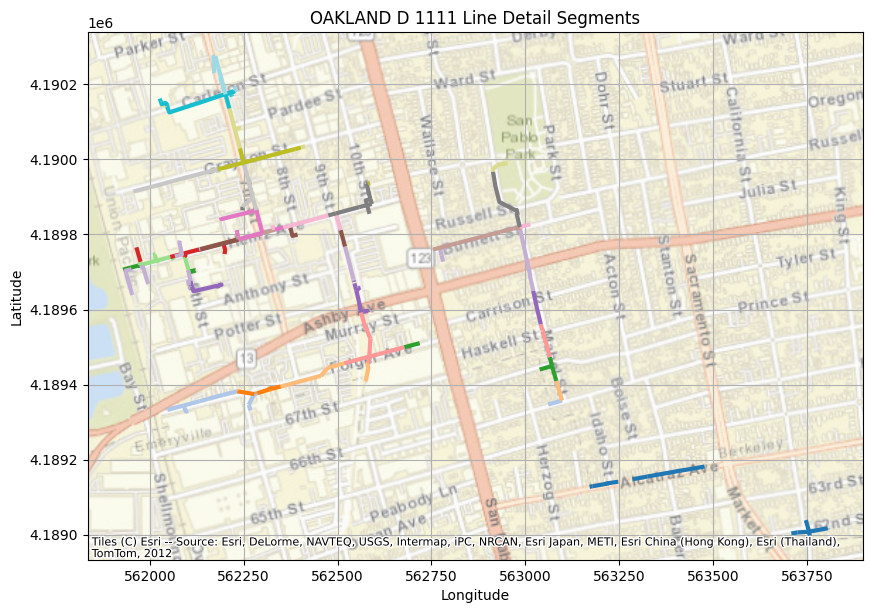

,FeederId,FeederName,Globalid,CSV_LineSection,ICA_Analysis_Date,LoadCapacity_kW,GenCapacity_kW,GenericPVCapacity_kW,GenCapacity_no_OpFlex_kW,GenericCapacity_no_OpFlex_kW,Shape_Length,geometry,LineID
0,012041111,OAKLAND D 1111,{B648966C-83FA-4A8A-ACC8-D90223749F11},5204485,Jul 2023,1620,2010,2480,2010,2480,43.515949,"LINESTRING (563708.801 4189003.394, 563725.095...",0
1,012041111,OAKLAND D 1111,{6FB241D4-9149-4453-9F2A-89650E9106B2},4239644,Jul 2023,1600,2020,2490,2020,2490,10.906521,"LINESTRING (563756.115 4189008.243, 563757.705...",1
2,012041111,OAKLAND D 1111,{7C60D4D6-8283-4B96-A6EA-4991A83AC8F6},5410279,Jul 2023,1600,2020,2480,2020,2480,28.790146,"LINESTRING (563725.095 4189006.233, 563753.825...",2
3,012041111,OAKLAND D 1111,{3BACE0B3-F647-40C0-AEB5-C7B19EB4B2D7},5445577,Jul 2023,1610,2020,2490,2020,2490,2.279035,"LINESTRING (563758.355 4189008.663, 563756.115...",3
4,012041111,OAKLAND D 1111,{EFE3C5D1-E0B9-458B-B3EA-2F63911A5373},5440041,Jul 2023,1620,2020,2490,2020,2490,6.821864,"LINESTRING (563753.825 4189008.093, 563754.085...",4


In [93]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D

# Check line coordinate reference system
line.crs
feeder_names = ['OAKLAND D 1111'] # 'RUSSELL 0401', 'OAKLAND D 1105'

# Get SF city boundaries
city_limits = gpd.read_file("../data/raw/City_Boundaries", driver='fileGDB')
city = city_limits.loc[city_limits.CITY.isin(['Berkeley'])] # , 'Oakland', 'Piedmont'])]

# Get lines pertaining to SF
city_lines = gpd.clip(line, city.to_crs(line.crs))
feeder_lines = city_lines.loc[city_lines.FeederName.isin(feeder_names)]


# Ensure each line has a unique identifier for coloring
feeder_lines = feeder_lines.reset_index(drop=True)  # Reset the index
feeder_lines['LineID'] = feeder_lines.index  # Create a new column to represent line IDs

# Plot the filtered lines, assigning different colors using a colormap
fig, ax = plt.subplots(figsize=(10, 10))

# Use the 'tab20' colormap for up to 20 unique colors (adjust accordingly)
cmap = plt.get_cmap('tab20', len(feeder_lines))


# Plot with different colors
feeder_lines.plot(column='LineID', cmap=cmap, ax=ax, linewidth=3, legend=False)
# feeder_lines.to_crs(line.crs).plot(ax=ax, edgecolor='blue', facecolor='none', linewidth=2, alpha=1)
ctx.add_basemap(ax, crs=line.crs.to_string(), source=ctx.providers.Esri.WorldStreetMap, alpha=0.8)

feeder_names_str = ', '.join(feeder_names)
ax.set_title(f"{feeder_names_str} Line Detail Segments")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
# ax.legend(handles=legend_elements, title='Line Details', loc='upper left')
plt.grid(True)
plt.show()

feeder_lines.head()

In [97]:
unique_feeder_names = city_lines['FeederName'].unique()  # Extract unique feeder names as a NumPy array

for feeder in unique_feeder_names:
    print(f'Feeder: {feeder}')

number_of_unique_feeders = len(unique_feeder_names)
print(f'Total unique feeders: {number_of_unique_feeders}')

Feeder: OAKLAND D 1105
Feeder: OAKLAND D 1111
Feeder: RUSSELL 0401
Feeder: OAKLAND D 1130
Feeder: OAKLAND D 1116
Feeder: OAKLAND D 1106
Feeder: EL CERRITO G 1104
Feeder: OAKLAND D 1134
Feeder: RUSSELL 0402
Feeder: BERKELEY T 0402
Feeder: OAKLAND D 1112
Feeder: STUART 0402
Feeder: STUART 0401
Feeder: EL CERRITO G 1103
Feeder: EL CERRITO G 1109
Feeder: EL CERRITO G 1110
Feeder: EL CERRITO G 1113
Feeder: EL CERRITO G 1107
Feeder: BERKELEY F 0411
Feeder: OAKLAND D 0410
Feeder: OAKLAND K 1101
Feeder: STUART 0406
Feeder: BERKELEY F 1104
Feeder: BERKELEY T 0404
Feeder: BERKELEY F 1103
Feeder: STUART 0405
Feeder: STUART 0403
Feeder: STUART 0404
Feeder: BERKELEY T 0401
Feeder: BERKELEY F 0409
Feeder: BERKELEY T 0403
Feeder: BERKELEY F 1102
Feeder: BERKELEY F 0406
Feeder: BERKELEY F 0401
Feeder: BERKELEY F 0407
Feeder: BERKELEY F 0408
Feeder: BERKELEY F 0405
Feeder: BERKELEY F 1105
Feeder: BERKELEY F 0404
Feeder: BERKELEY F 0403
Feeder: BERKELEY F 0410
Feeder: BERKELEY F 0402
Feeder: RIDGE 0402
